In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np

from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
days_to_predict = int(input('How many days from today do you want to predict? '))
print(days_to_predict)

How many days from today do you want to predict? 3
3


In [ ]:
import datetime
today =  datetime.date.today()
year_today = today.year
month_today = today.month
day_today = today.day

future = datetime.date.today() + datetime.timedelta(days=days_to_predict)
year_future = future.year
month_future = future.month
day_future = future.day

future_df = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range(today, future,
                                      freq='30T'))
       .between_time('09:30','15:30')
       .index.strftime('%Y-%m-%d %H:%M:%S')
       .tolist()
)

future_df = pd.DataFrame(future_df, columns=['created_at'])
future_df['created_at'] = future_df["created_at"].apply(pd.to_datetime)
future_df = future_df[future_df['created_at'].dt.weekday < 5]
future_df = future_df.set_index('created_at')
future_df['Close'] = np.nan
future_df['Comp'] = np.nan
future_df

,Close,Comp
created_at,,
2021-03-25 09:30:00,NaN,NaN
2021-03-25 10:00:00,NaN,NaN
2021-03-25 10:30:00,NaN,NaN
2021-03-25 11:00:00,NaN,NaN
2021-03-25 11:30:00,NaN,NaN
2021-03-25 12:00:00,NaN,NaN
2021-03-25 12:30:00,NaN,NaN
2021-03-25 13:00:00,NaN,NaN
2021-03-25 13:30:00,NaN,NaN


In [ ]:
predict_rows = len(future_df)
print(predict_rows)

26


In [ ]:
final = pd.read_csv('/content/drive/MyDrive/FA PROJECT 2021/LSTM/NVAX/final.csv') 
final = final.set_index('Datetime')
final.head()

,Close,Comp
Datetime,,
2021-01-21 09:30:00,125.140099,0.296000
2021-01-21 10:30:00,127.050003,0.000000
2021-01-21 11:00:00,129.000000,0.401900
2021-01-21 11:30:00,127.809998,0.214233
2021-01-21 12:00:00,126.500000,0.000000


In [ ]:
#Scaling for dataframes with 2 columns
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
sc = MinMaxScaler()
 
DataScaler = sc.fit(final)
X = DataScaler.transform(final)

In [ ]:
#Scaling for dataframes with 1 column
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
df_price = final.drop(columns='Comp')

sc_y = MinMaxScaler()
 
DataScaler_y = sc_y.fit(df_price)
Y = DataScaler_y.transform(df_price)

In [ ]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps= 26  # Price Prediction for n days is based on last how many rows of data, 26 = 2 days
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [ ]:
X_data=np.array(X_samples)
X_data.shape

(474, 26, 2)

In [ ]:
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], -1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], -1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(474, 26, 2)

#### Output Data shape ####
(474, 2)


In [ ]:
# Choosing the number of testing data records
TestingRecords= round(0.2 * y_data.shape[0]) #take 20% of the data for testing

# Splitting the data into train and test
#https://datascience.stackexchange.com/questions/30762/how-to-predict-the-future-values-of-time-horizon-with-keras
X_train=X_data[:-TestingRecords+predict_rows]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords+predict_rows]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(405, 26, 2)
(405, 2)

#### Testing Data shape ####
(95, 26, 2)
(95, 2)


In [ ]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 26
Number of Features: 2


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'tanh', return_sequences=False ))
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 50)
 
EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/50
81/81 [==============================] - 5s 16ms/step - loss: 0.0863
Epoch 2/50
81/81 [==============================] - 1s 15ms/step - loss: 0.0335
Epoch 3/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0340
Epoch 4/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0319
Epoch 5/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0316
Epoch 6/50
81/81 [==============================] - 1s 18ms/step - loss: 0.0309
Epoch 7/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0318
Epoch 8/50
81/81 [==============================] - 1s 18ms/step - loss: 0.0316
Epoch 9/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0323
Epoch 10/50
81/81 [==============================] - 1s 18ms/step - loss: 0.0329
Epoch 11/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0300
Epoch 12/50
81/81 [==============================] - 1s 17ms/step - loss: 0.0336
Epoch 13/50
81/81 [==================

In [ ]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler_y.inverse_transform(predicted_Price)

# Getting the original price values for testing data
orig=y_test
orig=DataScaler_y.inverse_transform(y_test)

# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())

Accuracy: 90.32005524278856


In [ ]:
# Generating predictions on full data
TrainPredictions=DataScaler_y.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler_y.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=final[TimeSteps:]
FullDataOrig

FullDataOrig = FullDataOrig.append(future_df)
FullDataOrig['Predicted_Close'] = FullDataPredictions
FullDataOrig

,Close,Comp,Predicted_Close
2021-01-25 12:30:00,128.690002,0.226300,186.164093
2021-01-25 13:00:00,129.078003,0.049100,187.699036
2021-01-25 13:30:00,129.919998,-0.027900,188.752289
2021-01-25 14:00:00,129.949997,0.443583,189.822205
2021-01-25 14:30:00,129.550003,0.305825,189.653824
...,...,...,...
2021-03-26 13:30:00,NaN,NaN,219.746490
2021-03-26 14:00:00,NaN,NaN,221.594009
2021-03-26 14:30:00,NaN,NaN,223.497849
2021-03-26 15:00:00,NaN,NaN,224.669647


In [ ]:
FullDataOrig.index=FullDataOrig.index.astype(str)
FullDataOrig

,Close,Comp,Predicted_Close
2021-01-25 12:30:00,128.690002,0.226300,186.164093
2021-01-25 13:00:00,129.078003,0.049100,187.699036
2021-01-25 13:30:00,129.919998,-0.027900,188.752289
2021-01-25 14:00:00,129.949997,0.443583,189.822205
2021-01-25 14:30:00,129.550003,0.305825,189.653824
...,...,...,...
2021-03-26 13:30:00,NaN,NaN,219.746490
2021-03-26 14:00:00,NaN,NaN,221.594009
2021-03-26 14:30:00,NaN,NaN,223.497849
2021-03-26 15:00:00,NaN,NaN,224.669647


In [ ]:
from statsmodels.tools.eval_measures import rmse

df1 = FullDataOrig.dropna()
error = rmse(df1['Predicted_Close'],df1['Close'])
error

29.781886955332773

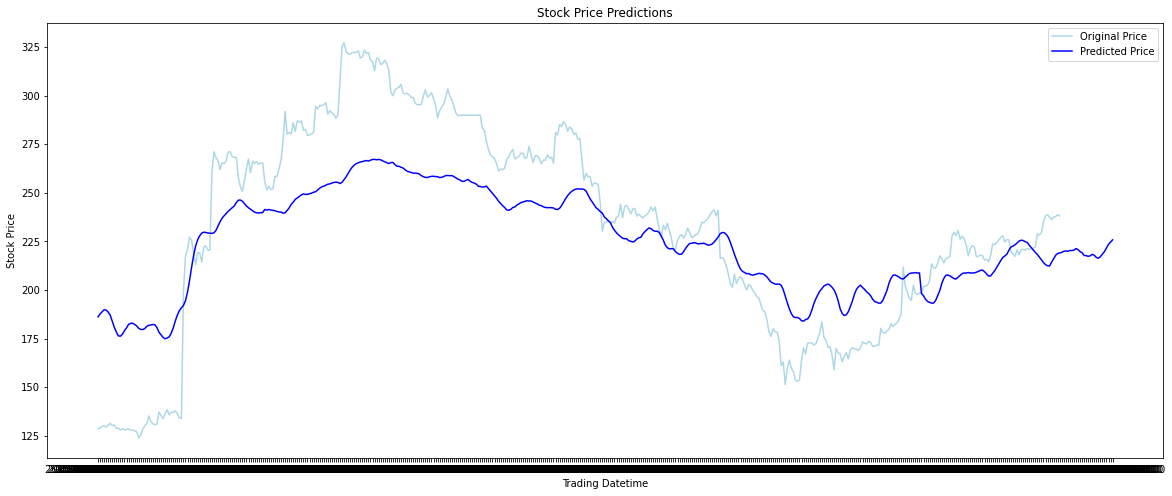

In [ ]:
# plotting the full data
plt.plot(FullDataOrig['Close'] , color = 'lightblue', label = 'Original Price')
plt.plot(FullDataOrig['Predicted_Close'] , color = 'blue', label = 'Predicted Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Datetime')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()